# Deep Averaging Networks for text classification

- pytorch, deep averaging networks, word embeddings, spacy
- S&P Key Developments, Wharton Research Data Services

Terence Lim


In [1]:
import numpy as np
import os
import time
import re
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from collections import Counter
from finds.database import MongoDB
from finds.unstructured import Unstructured
from finds.structured import PSTAT
from settings import settings
mongodb = MongoDB(**settings['mongodb'])
keydev = Unstructured(mongodb, 'KeyDev')
imgdir = os.path.join(settings['images'], 'classify')
event_ = PSTAT.event_
role_ = PSTAT.role_

## Show event sample counts
counts = {ev: keydev['events'].count_documents({'keydeveventtypeid': ev})
          for ev in keydev['events'].distinct('keydeveventtypeid')}

## Retrieve headline+situation text
# - in lower case, exclude numeric
events = [28, 16, 83, 41, 81, 23, 87, 45, 80, 97,  231, 46, 31, 77, 29,
          232, 101, 42, 47, 86, 93, 3, 22, 102, 82]
corpus = {}    #[16, 83] # #[65, 80]: #[101, 192, 65, 80, 27, 86]
for event in events:
    docs = keydev['events'].find({'keydeveventtypeid':{'$eq':event}}, {'_id':0})
    corpus[event] = [re.sub(r'\b\w*[\d]\w*\b', ' ', " ".join(
        d[k] for k in ['headline', 'situation'])).lower() for d in docs]
DataFrame({e: {'event': event_[e], 'count': counts[e]} for e in corpus.keys()})

,28,16,83,41,81,23,87,45,80,97,...,232,101,42,47,86,93,3,22,102,82
event,Announcements of Earnings,Executive/Board Changes - Other,Private Placements,Product-Related Announcements,M&A Transaction Closings,Client Announcements,Fixed Income Offerings,Dividend Affirmations,M&A Transaction Announcements,Special/Extraordinary Shareholders Meeting,...,Buyback Transaction Announcements,Executive Changes - CEO,Debt Financing Related,Dividend Decreases,Follow-on Equity Offerings,Shelf Registration Filings,Seeking Acquisitions/Investments,Strategic Alliances,Executive Changes - CFO,M&A Transaction Cancellations
count,244140,128019,113007,93172,90955,90687,69652,53704,43305,32572,...,17420,16291,15184,15161,14687,12793,12736,12045,11698,10076


## Collect all text into data, and encode labels


In [2]:
lines = []
event_all = []
for label, event in enumerate(events):
    lines.extend(corpus[event])
    event_all.extend([event] * len(corpus[event]))
print(lines[0])

from sklearn.preprocessing import LabelEncoder
event_encoder = LabelEncoder().fit(event_all)    # .inverse_transform()
num_classes = len(np.unique(event_all))
y_all = event_encoder.transform(event_all)


life healthcare group holdings limited reports audited consolidated earnings results for the year ended september  ,   life healthcare group holdings limited reported audited consolidated earnings results for the year ended september  ,  . for the year, the company reported revenue of zar  ,  million compared to zar  ,  million a year ago. operating profit was zar  ,  million compared to zar  ,  million a year ago. profit before tax was zar  ,  million compared to zar  ,  million a year ago. profit after tax was zar  ,  million compared to zar  ,  million a year ago. diluted earnings per share were  .  cents compared to  .  cents a year ago. 


## split into train and test indices
- stratify by event label frequencies

In [3]:
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(np.arange(len(y_all)), random_state=0,
                                       stratify=y_all, test_size=0.1)

## Load spacy and vocab


In [4]:
import spacy
lang = 'en_core_web_lg'
nlp = spacy.load(lang, disable=['parser', 'tagger', 'ner', 'lemmatizer'])
for w in ['yen', 'jpy', 'eur', 'dkk', 'cny', 'sfr']:
    nlp.vocab[w].is_stop = True    # Mark customized stop words

n_vocab, vocab_dim = nlp.vocab.vectors.shape
print('Language:', lang, '   vocab:', n_vocab, '   dim:', vocab_dim)


Language: en_core_web_lg    vocab: 684830    dim: 300


## Load Pytorch and define Deep Averaging Network

- FFNN with averaged bag of word embeddings

In [5]:
import torch
import torch.nn as nn
import random
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# helpers to form inputs and outputs
def form_input(text, nlp):
    """Return LongTensor (as input to embedding) of vocab rows of valid tokens"""
    # TODO: pad with '.' which is row id 0???
    tokens = [[tok.lex_id for tok in nlp(line)  # apply spacy nlp on tokens
               if not(tok.is_stop or tok.is_punct or tok.is_oov or tok.is_space)]
              for line in text]
    n = [len(token) for token in tokens]
    max_len = max(n)
    if max_len:
        tokens = [token + random.choices(token, k=max_len-length) if length
                  else [0]*max_len for token, length in zip(tokens, n)]
    else:
        tokens = [[0]]
    return torch.LongTensor(tokens)

# Pytorch Deep Averaging Feed Forward Network
class FFNN(nn.Module):
    """Deep Averaging Network for classification"""
    def __init__(self, vocab_dim, num_classes, hidden, word_vec=None,
                 dropout=0.3):
        super().__init__()
        self.prebagged = word_vec is None  # whether input is prebagged vector
        self.embedding_ = ((lambda x: x) if self.prebagged
                           else nn.EmbeddingBag.from_pretrained(word_vec))
        V = nn.Linear(vocab_dim, hidden[0])
        nn.init.xavier_uniform_(V.weight)
        L = [V, nn.Dropout(dropout)]
        for g, h in zip(hidden, hidden[1:] + [num_classes]):
            W = nn.Linear(g, h)
            nn.init.xavier_uniform_(W.weight)
            L.extend([nn.ReLU(), W])
        self.network = nn.Sequential(*L)
        self.classifier = nn.LogSoftmax(dim=-1)  # output is (N, C) logits

    def embedding(self, x):
        """Apply embedding, if any; else assumes input is weights vector"""
        return self.embedding_(x)

    def forward(self, x):
        """Return tensor of log probabilities"""
        return self.classifier(self.network(self.embedding_(x)))

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self

## Optionally, precompute word embeddings input

- Model may optionally be run with pre-computed input word embeddings, for faster training 


In [6]:
if True:  # to use precomputed embeddings bag
    from settings import pickle_dump, pickle_load
    if False:  # to precompute bag of inpu word vec weights
        word_vec = torch.FloatTensor(nlp.vocab.vectors.data)
        model = FFNN(vocab_dim, num_classes, hidden=[300], word_vec=word_vec)
        model.eval()
        with torch.no_grad():
            X = np.zeros((len(lines), vocab_dim))
            i, line = 0, lines[0]
            for i, line in tqdm(enumerate(lines)):
                if i >= 0:
                    x = form_input([line], nlp)
                    y = model.embedding(x)
                    X[i] = y
        pickle_dump(X, 'X.pkl', outdir=imgdir)
        pickle_dump([lines, y_all], 'lines_y.pkl', outdir=imgdir)
    else:
        X = pickle_load('X.pkl', outdir=imgdir)
    word_vec = None
else:
    word_vec = torch.FloatTensor(nlp.vocab.vectors.data).to(device)

## Training Loops
- Instantiate model, optimizer, scheduler, loss_function for range of layers selection
- Loops over epochs and batches

In [7]:
results = {}
max_layers, hidden = 3, 450
for layers in range(1, max_layers+1):
    results[layers] = {}
    batch_size, lr, num_lr = 64, 0.01, 3
    step_size = 100
    num_epochs = step_size * num_lr
    model = FFNN(vocab_dim, num_classes, hidden=[hidden // layers]*layers,
                 word_vec=word_vec).to(device)
    #model = model.load(os.path.join(imgdir, f"dan_{layers}.pt")).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1,
                                                step_size=step_size)
    loss_function = nn.NLLLoss()
    for epoch in range(0, num_epochs):
        tic = time.time()
        idxs = [i for i in train_idx]
        random.shuffle(idxs)
        batches = [idxs[i:(i+batch_size)] for i in range(0,len(idxs),batch_size)]
        batch = batches[0]
    
        # train by batch
        total_loss = 0.0
        model.train()
        for batch in batches:
            x = (torch.FloatTensor(X[batch]) if model.prebagged
                 else form_input([lines[idx] for idx in batch], nlp)).to(device)
            y = torch.tensor([y_all[idx] for idx in batch]).to(device)
            model.zero_grad()                    # reset model gradient
            log_probs = model(x)                 # run model
            loss = loss_function(log_probs, y)   # compute loss
            total_loss += float(loss)
            loss.backward()      # loss step
            optimizer.step()     # optimizer step
        scheduler.step()      # scheduler step
        model.eval()
        if model.prebagged: model.save(os.path.join(imgdir, f"dan{layers}.pt"))
        if (epoch + 1) % step_size == 0:
            print(layers, epoch, int(time.time()-tic),
                  optimizer.param_groups[0]['lr'], total_loss)

    with torch.no_grad():
        test_pred = [int(torch.argmax(model(torch.FloatTensor([X[idx]])\
                                            .to(device)[0])))
                         for idx in test_idx]
        test_gold = [int(y_all[idx]) for idx in test_idx]
        test_correct = (np.asarray(test_pred) == np.asarray(test_gold)).sum()
        train_pred = [int(torch.argmax(model(torch.FloatTensor([X[idx]])\
                                             .to(device)[0])))
                      for idx in train_idx]
        train_gold = [int(y_all[idx]) for idx in train_idx]
        train_correct = (np.asarray(train_pred) ==
                         np.asarray(train_gold)).sum()
        results[layers][epoch] = {'train': train_correct,
                                       'test': test_correct}
        #if True: #epoch % step_size == 0:
        #    print(layers, epoch, int(time.time()-tic),
        #          optimizer.param_groups[0]['lr'],
        #          train_correct/len(train_idx), test_correct/len(test_idx))

    from sklearn import metrics
    print(model)
    print(pd.concat([
        Series({'Accuracy':  metrics.accuracy_score(test_gold, test_pred),
                'Precision': metrics.precision_score(test_gold, test_pred,
                                                     average='weighted'),
                'Recall': metrics.recall_score(test_gold, test_pred,
                                               average='weighted')},
               name='Test Set').to_frame().T,      
        Series({'Accuracy': metrics.accuracy_score(train_gold, train_pred),
                'Precision': metrics.precision_score(train_gold, train_pred,
                                                     average='weighted'),
                'Recall': metrics.recall_score(train_gold, train_pred,
                                               average='weighted')},
               name='Train Set').to_frame().T], axis=0).to_string())

1 99 18 0.001 6396.066624678671
1 199 19 0.0001 4861.842247862369
1 299 19 1e-05 4702.664552491158
FFNN(
  (network): Sequential(
    (0): Linear(in_features=300, out_features=450, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=450, out_features=25, bias=True)
  )
  (classifier): LogSoftmax(dim=-1)
)
           Accuracy  Precision    Recall
Test Set   0.906450   0.900583  0.906450
Train Set  0.912283   0.915944  0.912283
2 99 24 0.001 8200.139961324632
2 199 24 0.0001 5650.156769808382
2 299 24 1e-05 5561.424403142184
FFNN(
  (network): Sequential(
    (0): Linear(in_features=300, out_features=225, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=225, out_features=225, bias=True)
    (4): ReLU()
    (5): Linear(in_features=225, out_features=25, bias=True)
  )
  (classifier): LogSoftmax(dim=-1)
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           Accuracy  Precision    Recall
Test Set   0.901132   0.881096  0.901132
Train Set  0.905473   0.885477  0.905473
3 99 28 0.001 6914.171044319868
3 199 29 0.0001 4702.456170253456
3 299 29 1e-05 4634.393382333219
FFNN(
  (network): Sequential(
    (0): Linear(in_features=300, out_features=150, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=150, out_features=150, bias=True)
    (4): ReLU()
    (5): Linear(in_features=150, out_features=150, bias=True)
    (6): ReLU()
    (7): Linear(in_features=150, out_features=25, bias=True)
  )
  (classifier): LogSoftmax(dim=-1)
)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           Accuracy  Precision    Recall
Test Set   0.904979   0.884601  0.904979
Train Set  0.909309   0.889094  0.909309


## Show accuracy

In [8]:
results

{1: {299: {'train': 1005176, 'test': 110973}},
 2: {299: {'train': 997673, 'test': 110322}},
 3: {299: {'train': 1001899, 'test': 110793}}}

## Confusion Matrix

- Both test set and especially training set classification accuracy were poorer compared to statistical learning models, which also used stemmed and lemmatized word inputs encoded as one-hot features.
- When specific words are required to determine classification, average word embeddings (where many words appear similar) may not work as well as distinct word indexes.

In [12]:
from sklearn.metrics import confusion_matrix
labels = [event_[e] for e in event_encoder.classes_]
cf_train = DataFrame(confusion_matrix(train_gold, train_pred),
              index=pd.MultiIndex.from_product([['Actual'], labels]),
              columns=pd.MultiIndex.from_product([['Predicted'], labels]))
cf_train

Predicted  \
                                                  Seeking Acquisitions/Investments   
Actual Seeking Acquisitions/Investments                                      11238   
       Executive/Board Changes - Other                                           6   
       Strategic Alliances                                                       0   
       Client Announcements                                                      0   
       Announcements of Earnings                                                 0   
       Corporate Guidance - New/Confirmed                                        0   
       Business Expansions                                                      10   
       Product-Related Announcements                                             1   
       Debt Financing Related                                                    5   
       Dividend Affirmations                                                     0   
       Dividend Increases                                                        0   
       Dividend Decreases                                                        0   
       Changes in Company Bylaws/Rules                                           1   
       M&A Transaction Announcements                                             4   
       M&A Transaction Closings                                                  0   
       M&A Transaction Cancellations                                             0   
       Private Placements                                                        0   
       Follow-on Equity Offerings                                                0   
       Fixed Income Offerings                                                    0   
       Shelf Registration Filings                                                0   
       Special/Extraordinary Shareholders Meeting                                0   
       Executive Changes - CEO                                                   1   
       Executive Changes - CFO                                                   0   
       Buyback Tranche Update                                                    0   
       Buyback Transaction Announcements                                         0   

                                                                                   \
                                                  Executive/Board Changes - Other   
Actual Seeking Acquisitions/Investments                                        22   
       Executive/Board Changes - Other                                     111286   
       Strategic Alliances                                                     44   
       Client Announcements                                                   273   
       Announcements of Earnings                                                0   
       Corporate Guidance - New/Confirmed                                       3   
       Business Expansions                                                    276   
       Product-Related Announcements                                           98   
       Debt Financing Related                                                  13   
       Dividend Affirmations                                                   14   
       Dividend Increases                                                       8   
       Dividend Decreases                                                       2   
       Changes in Company Bylaws/Rules                                         10   
       M&A Transaction Announcements                                           60   
       M&A Transaction Closings                                               119   
       M&A Transaction Cancellations                                            6   
       Private Placements                                                      14   
       Follow-on Equity Offerings                                               0   
       Fixed Income Offerings                     

In [13]:
cf_test = DataFrame(confusion_matrix(test_gold, test_pred),
                    index=pd.MultiIndex.from_product([['Actual'], labels]),
                    columns=pd.MultiIndex.from_product([['Predicted'], labels]))
cf_test

Predicted  \
                                                  Seeking Acquisitions/Investments   
Actual Seeking Acquisitions/Investments                                       1241   
       Executive/Board Changes - Other                                           1   
       Strategic Alliances                                                       1   
       Client Announcements                                                      0   
       Announcements of Earnings                                                 0   
       Corporate Guidance - New/Confirmed                                        0   
       Business Expansions                                                       3   
       Product-Related Announcements                                             1   
       Debt Financing Related                                                    0   
       Dividend Affirmations                                                     0   
       Dividend Increases                                                        0   
       Dividend Decreases                                                        0   
       Changes in Company Bylaws/Rules                                           0   
       M&A Transaction Announcements                                             2   
       M&A Transaction Closings                                                  2   
       M&A Transaction Cancellations                                             0   
       Private Placements                                                        0   
       Follow-on Equity Offerings                                                0   
       Fixed Income Offerings                                                    1   
       Shelf Registration Filings                                                0   
       Special/Extraordinary Shareholders Meeting                                0   
       Executive Changes - CEO                                                   0   
       Executive Changes - CFO                                                   0   
       Buyback Tranche Update                                                    0   
       Buyback Transaction Announcements                                         0   

                                                                                   \
                                                  Executive/Board Changes - Other   
Actual Seeking Acquisitions/Investments                                         2   
       Executive/Board Changes - Other                                      12341   
       Strategic Alliances                                                      7   
       Client Announcements                                                    28   
       Announcements of Earnings                                                1   
       Corporate Guidance - New/Confirmed                                       0   
       Business Expansions                                                     40   
       Product-Related Announcements                                           13   
       Debt Financing Related                                                   2   
       Dividend Affirmations                                                    3   
       Dividend Increases                                                       1   
       Dividend Decreases                                                       0   
       Changes in Company Bylaws/Rules                                          2   
       M&A Transaction Announcements                                            9   
       M&A Transaction Closings                                                21   
       M&A Transaction Cancellations                                            1   
       Private Placements                                                       1   
       Follow-on Equity Offerings                                               0   
       Fixed Income Offerings                     

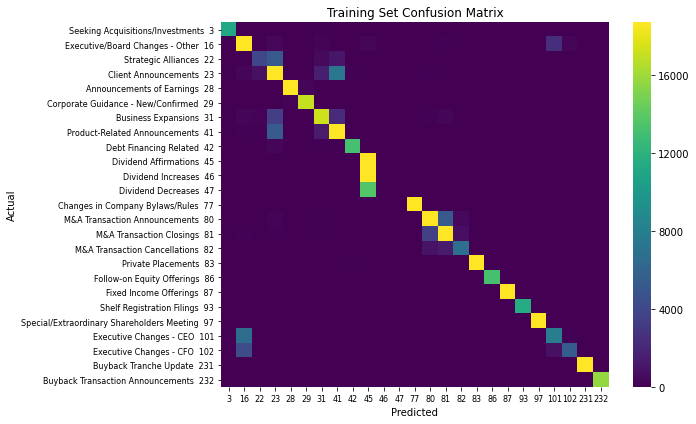

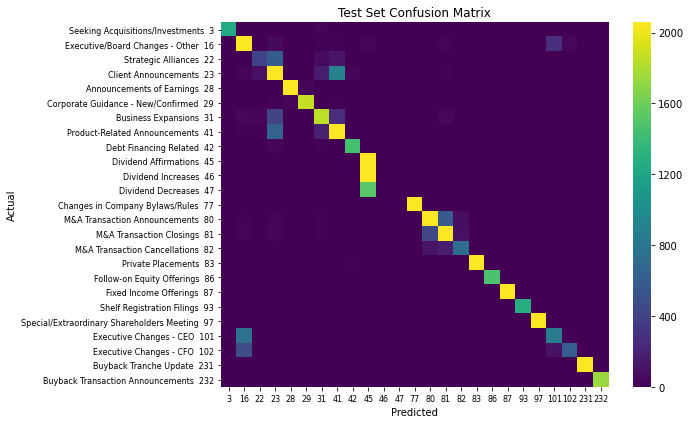

In [14]:
import seaborn as sns
for num, (title, cf) in enumerate({'Training': cf_train, 'Test': cf_test}.items()):
    fig, ax = plt.subplots(num=1+num, clear=True, figsize=(10,6))
    sns.heatmap(cf, ax=ax, annot= False, fmt='d', cmap='viridis', robust=True,
                yticklabels=[f"{label}  {e}" for label, e in zip(labels, event_encoder.classes_)],
                xticklabels=event_encoder.classes_)
    ax.set_title(f'{title} Set Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.yaxis.set_tick_params(labelsize=8, rotation=0)
    ax.xaxis.set_tick_params(labelsize=8, rotation=0)
    plt.subplots_adjust(left=0.35, bottom=0.25)
    plt.savefig(os.path.join(imgdir, f"cf_{title}.jpg"))
    plt.tight_layout()
plt.show()


# Spacy Explorations
- hashkey = nlp.vocab.strings[v] : general hash table between vocab strings and ids
- vec = nlp.vocab[v].vector : np array with word embedding vector from vocab string
- row = nlp.vocab.vectors.key2row : dict from word's hashkey to int

- emb = nn.Embedding.from_pretrained(torch.FloatTensor(nlp.vocab.vectors.data))
- emb(row) == vec : equivalence of torch embedding and spacy vector

- token = nlp('king man queen woman')[0]
- token.lower : hashkey
- token.lower_: str
- token.lex_id : row of word vector
- token.has_vector : has word vector representation


In [43]:
doc = nlp('king queen man woman a23kj4j')
line = [tok.lex_id for tok in doc
        if not(tok.is_stop or tok.is_punct or tok.is_oov or tok.is_space)]

vec = (nlp.vocab['king'].vector
       - nlp.vocab['man'].vector
       + nlp.vocab['woman'].vector)
print(vec.shape)
sim = nlp.vocab.vectors.most_similar(vec[None,:], n=10)
[nlp.vocab.strings[hashkey] for hashkey in sim[0][0]]

(300,)


['KIng',
 'King',
 'king',
 'KING',
 'Queen',
 'queen',
 'QUEEN',
 'PRINCE',
 'prince',
 'Prince']

In [46]:
# Load pretrained embeddings
emb = nn.Embedding.from_pretrained(torch.FloatTensor(nlp.vocab.vectors.data))

# test for Spacy.nlp and torch.embeddings
test_vocab = ['king', 'man', 'woman', 'queen', 'e9s82j']
for w in test_vocab:
    vocab_id = nlp.vocab.strings[w]
    spacy_vec = nlp.vocab[w].vector
    row = nlp.vocab.vectors.key2row.get(vocab_id, None) # dict 
    if row is None:
        print('{} is oov'.format(w))
        continue
    vocab_row = torch.tensor(row, dtype=torch.long)
    embed_vec = emb(vocab_row)
    print(np.allclose(spacy_vec, embed_vec.detach().numpy()))

for key, row in nlp.vocab.vectors.key2row.items():
    if row == 0: 
        print(nlp.vocab.strings[key])

True
True
True
True
e9s82j is oov
.
